In [ ]:
import yfinance as yf

ticker_symbol = 'AAPL' #company_ticket

stock_data = yf.download(ticker_symbol, start='2015-01-01', end ='2025-10-24')

print(stock_data)

/tmp/ipython-input-712653216.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start='2015-01-01', end ='2025-10-24')
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2015-01-02   24.261047   24.729270   23.821672   24.718174  212818400
2015-01-05   23.577572   24.110148   23.391171   24.030261  257142000
2015-01-06   23.579796   23.839426   23.218087   23.641929  263188400
2015-01-07   23.910431   24.010288   23.677428   23.788382  160423600
2015-01-08   24.829128   24.886824   24.121246   24.238858  237458000
...                ...         ...         ...         ...        ...
2025-10-17  252.289993  253.380005  247.270004  248.020004   49147000
2025-10-20  262.239990  264.380005  255.630005  255.889999   90483000
2025-10-21  262.769989  265.290009  261.829987  261.880005   46695900
2025-10-22  258.450012  262.850006  255.429993  262.649994   45015300
2025-10-23  259.579987  260.619995  258.010010  259.940002   32754900

[2719 rows x 5 colu

/tmp/ipython-input-3628154611.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start='2024-01-01', end='2025-10-01')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Simple RNN...
Training LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

Simple RNN Evaluation Metrics:
  MSE  : 0.003322
  RMSE : 0.057635
  MAE  : 0.041853
  R²   : 0.898643
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

LSTM Evaluation Metrics:
  MSE  : 0.005114
  RMSE : 0.071514
  MAE  : 0.053983
  R²   : 0.843948


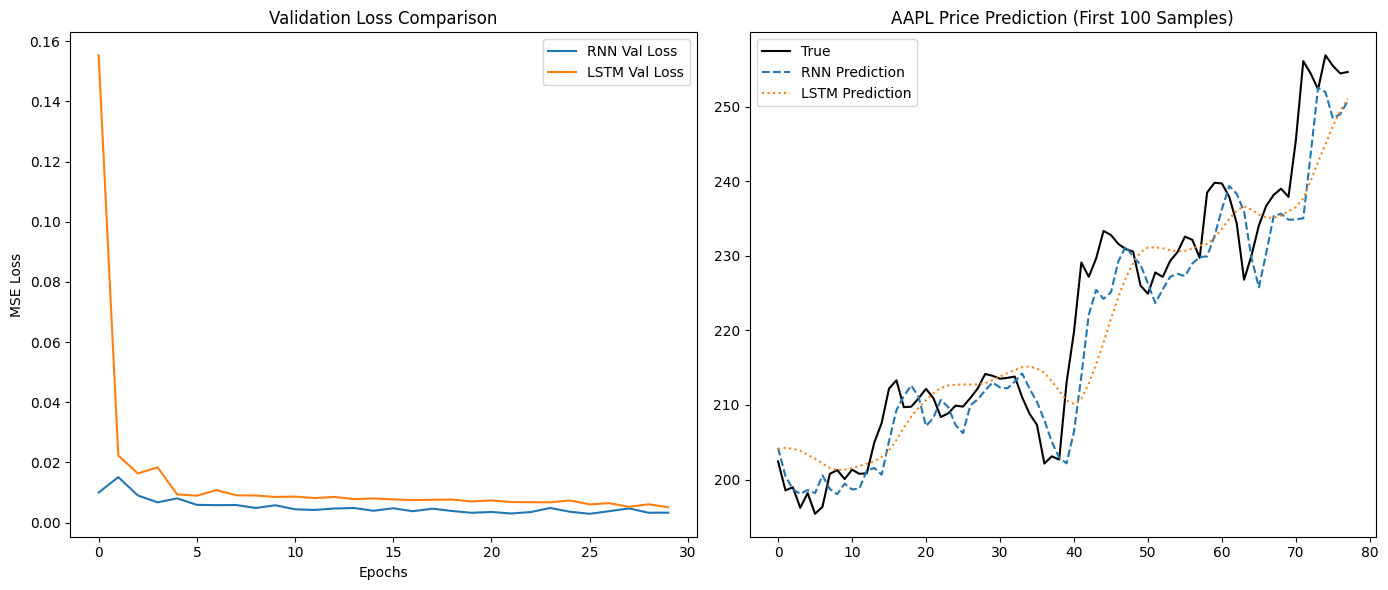

In [ ]:
# ================== STOCK PRICE PREDICTION: RNN vs LSTM ==================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf

# ---------------------- DATA LOADING ----------------------
ticker_symbol = 'AAPL'
stock_data = yf.download(ticker_symbol, start='2024-01-01', end='2025-10-01')
data = stock_data['Close'].values.reshape(-1, 1)

# DATA PREPROCESSING
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

seq_length = 50
X, y = [], []
for i in range(seq_length, len(data_scaled)):
    X.append(data_scaled[i-seq_length:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# SIMPLE RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(seq_length, 1)),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')

print("Training Simple RNN...")
rnn_history = rnn_model.fit(X_train, y_train, epochs=30, batch_size=32,
                            validation_data=(X_test, y_test), verbose=0)

# LSTM
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

print("Training LSTM...")
lstm_history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32,
                              validation_data=(X_test, y_test), verbose=0)

# METRICS
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Evaluation Metrics:")
    print(f"  MSE  : {mse:.6f}")
    print(f"  RMSE : {rmse:.6f}")
    print(f"  MAE  : {mae:.6f}")
    print(f"  R²   : {r2:.6f}")
    return y_pred

y_pred_rnn = evaluate_model(rnn_model, X_test, y_test, "Simple RNN")
y_pred_lstm = evaluate_model(lstm_model, X_test, y_test, "LSTM")

# PLOTS
plt.figure(figsize=(14,6))

# Validation loss
plt.subplot(1,2,1)
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Predictions (rescaled to original prices)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_rnn_rescaled = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)

plt.subplot(1,2,2)
plt.plot(y_test_rescaled[:100], label='True', color='black')
plt.plot(y_pred_rnn_rescaled[:100], label='RNN Prediction', linestyle='dashed')
plt.plot(y_pred_lstm_rescaled[:100], label='LSTM Prediction', linestyle='dotted')
plt.title(f"{ticker_symbol} Price Prediction (First 100 Samples)")
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-1328717952.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_raw = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Simple RNN...
Training LSTM...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Simple RNN Metrics:
  MSE  : 0.000343
  RMSE : 0.018533
  MAE  : 0.014650
  R²   : 0.979601
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step

LSTM Metrics:
  MSE  : 0.000409
  RMSE : 0.020232
  MAE  : 0.014773
  R²   : 0.975690


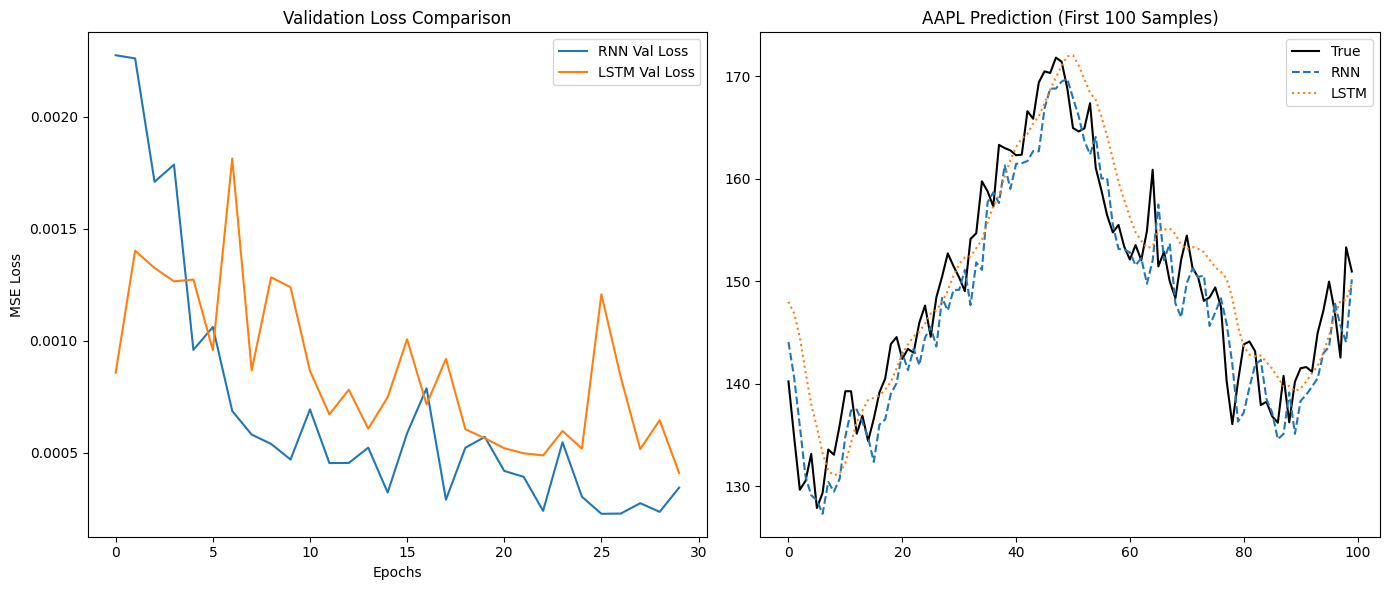

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Prediction for 2025-10-23:
  Predicted Close : 253.00
  Actual Close    : 259.58
  Error           : 6.58


(np.float64(253.00081184078502), np.float64(259.5799865722656))

In [ ]:
# ===================== STOCK PRICE PREDICTION: RNN vs LSTM =====================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf

# ---------------------- USER SETTINGS ----------------------
ticker = 'AAPL'
start_date = '2005-01-01'
end_date = '2025-10-27'
seq_length = 1000  # number of past days used to predict next day

# ---------------------- DATA LOADING ----------------------
data_raw = yf.download(ticker, start=start_date, end=end_date)
data = data_raw['Close'].values.reshape(-1, 1)

# ---------------------- DATA PREPROCESSING ----------------------
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences
X, y = [], []
for i in range(seq_length, len(data_scaled)):
    X.append(data_scaled[i - seq_length:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------- SIMPLE RNN ----------------------
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(seq_length, 1)),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
print("Training Simple RNN...")
rnn_history = rnn_model.fit(X_train, y_train, epochs=30, batch_size=32,
                            validation_data=(X_test, y_test), verbose=0)

# ---------------------- LSTM ----------------------
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
print("Training LSTM...")
lstm_history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32,
                              validation_data=(X_test, y_test), verbose=0)

# ---------------------- EVALUATION ----------------------
def evaluate(model, X_test, y_test, name):
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"\n{name} Metrics:")
    print(f"  MSE  : {mse:.6f}")
    print(f"  RMSE : {rmse:.6f}")
    print(f"  MAE  : {mae:.6f}")
    print(f"  R²   : {r2:.6f}")
    return preds

pred_rnn = evaluate(rnn_model, X_test, y_test, "Simple RNN")
pred_lstm = evaluate(lstm_model, X_test, y_test, "LSTM")

# ---------------------- PLOTS ----------------------
plt.figure(figsize=(14,6))

# Validation loss
plt.subplot(1,2,1)
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Predictions (first 100 samples)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
pred_rnn_rescaled = scaler.inverse_transform(pred_rnn)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)

plt.subplot(1,2,2)
plt.plot(y_test_rescaled[:100], label='True', color='black')
plt.plot(pred_rnn_rescaled[:100], label='RNN', linestyle='dashed')
plt.plot(pred_lstm_rescaled[:100], label='LSTM', linestyle='dotted')
plt.title(f"{ticker} Prediction (First 100 Samples)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------- SINGLE-DATE PREDICTION ----------------------
def predict_for_date(model, data_scaled, scaler, seq_length, data_original, data_raw, date_str):
    if date_str not in data_raw.index:
        print(f"Date {date_str} not found in dataset.")
        return None

    idx = data_raw.index.get_loc(date_str)
    if idx < seq_length:
        print(f"Not enough prior data to predict {date_str} (need {seq_length} days).")
        return None

    X_input = data_scaled[idx - seq_length:idx].reshape(1, seq_length, 1)
    pred_scaled = model.predict(X_input)[0,0]
    pred = scaler.inverse_transform([[pred_scaled]])[0,0]
    actual = data_original[idx,0]

    print(f"\nPrediction for {date_str}:")
    print(f"  Predicted Close : {pred:.2f}")
    print(f"  Actual Close    : {actual:.2f}")
    print(f"  Error           : {abs(pred - actual):.2f}")
    return pred, actual

# Example usage:
predict_for_date(
    lstm_model,
    data_scaled,
    scaler,
    seq_length,
    data,
    data_raw,
    '2025-10-23'
)
